# Importing essential libraries and functions

In [123]:
#importing essential libraries and functions
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
from sklearn.metrics import confusion_matrix

from keras.preprocessing.text import one_hot, Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split
!pip install keras_flops
from keras_flops import get_flops
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


# Loading dataset

In [9]:
movie_reviews=pd.read_csv("/Users/siddharthajith/Desktop/Data/IMDB_Dataset.csv")

In [10]:
movie_reviews.shape

(50000, 2)

In [12]:
movie_reviews.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [13]:
#checking for any missing values
movie_reviews.isnull().any()

review       False
sentiment    False
dtype: bool

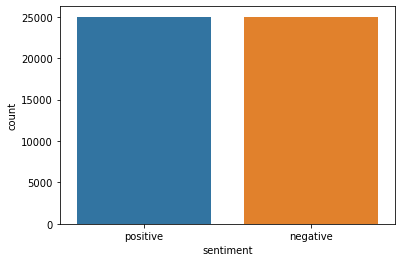

In [15]:
import seaborn as sns
sns.countplot(x='sentiment',data=movie_reviews)

# Data Preprocessing

In [16]:
movie_reviews['review'][2]
#the below text data contains punctuations, brackets, HTML tags and numbers which are not needed so preprocessing 
#is done in the next section

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [17]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [18]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/siddharthajith/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    
    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [20]:
# Calling preprocessing_text function on movie_reviews

X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [21]:
# Sample cleaned up movie review 

X[2]

# As we shall use Word Embeddings, stemming/lemmatization is not performed as a preprocessing step here

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

In [22]:
# Converting sentiment labels to 0 & 1

y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# The train set will be used to train the deep learning models 
# Test set will be used to evaluate how well the model performs 

In [24]:
#preparing embedding layer

# Embedding layer expects the words to be in numeric form 
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer 
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [25]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

92394

In [30]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [34]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/Users/siddharthajith/Desktop/Data/a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [35]:
# Create Embedding Matrix having 100 columns 
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [36]:
embedding_matrix.shape

(92394, 100)

#  Simple Nueral Network 

In [37]:
# Neural Network architecture

snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

In [38]:
# Model compiling

snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(snn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9239400   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 1)                 10001     
                                                                 
Total params: 9,249,401
Trainable params: 10,001
Non-trainable params: 9,239,400
_________________________________________________________________
None


In [39]:
# Model training

snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 6s 10ms/step - loss: 0.5556 - acc: 0.7169 - val_loss: 0.5017 - val_acc: 0.7600
Epoch 2/6
250/250 [==============================] - 2s 9ms/step - loss: 0.4485 - acc: 0.7946 - val_loss: 0.5023 - val_acc: 0.7596
Epoch 3/6
250/250 [==============================] - 2s 7ms/step - loss: 0.4120 - acc: 0.8155 - val_loss: 0.5030 - val_acc: 0.7619
Epoch 4/6
250/250 [==============================] - 2s 7ms/step - loss: 0.3890 - acc: 0.8272 - val_loss: 0.5106 - val_acc: 0.7611
Epoch 5/6
250/250 [==============================] - 2s 8ms/step - loss: 0.3746 - acc: 0.8358 - val_loss: 0.5191 - val_acc: 0.7591
Epoch 6/6
250/250 [==============================] - 2s 7ms/step - loss: 0.3626 - acc: 0.8434 - val_loss: 0.5419 - val_acc: 0.7529


In [120]:
# Predictions on the Test Set
y_pred_snn=snn_model.predict(X_test)
score = snn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 1s 3ms/step - loss: 0.5636 - acc: 0.7472


In [121]:
#threshholding y_pred_cnn and converting real values to 0 and 1.
y_pred_snn=np.array(y_pred_snn)
y_pred_snn.shape
m=len(y_pred_snn)
for i in range(m):
    if y_pred_snn[i]>0.5:
        y_pred_snn[i]=1
    else:
        y_pred_snn[i]=0
print(y_test.T[:5])
print(y_pred_snn[:5])

[1 1 0 1 0]
[[0.]
 [1.]
 [0.]
 [0.]
 [0.]]


Test Score: 0.5635668635368347
Test Accuracy: 0.7472000122070312
              precision    recall  f1-score   support

           0       0.73      0.78      0.75      4961
           1       0.77      0.71      0.74      5039

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000

Flops(SNN):2e-05G


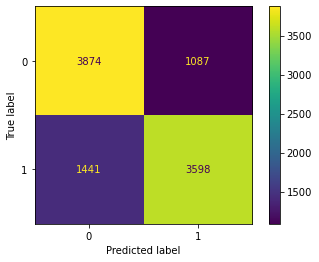

In [125]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])
print(classification_report(y_test,y_pred_snn))

#FlOPS computation
flops = get_flops(snn_model,batch_size=1)
print(f"Flops(SNN):{flops/10**9:.03}G")

#confusion matrix
cm = confusion_matrix(y_test, y_pred_snn)
cm_display = ConfusionMatrixDisplay(cm).plot()

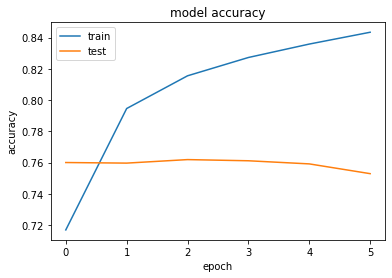

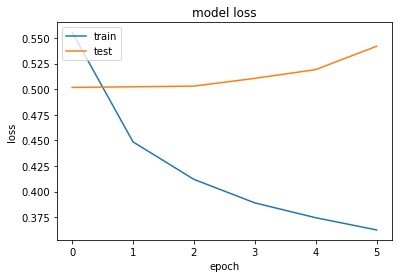

In [42]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Convolutional Neural Network 

In [43]:

from keras.layers import Conv1D

In [44]:
# Neural Network architecture

cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [45]:
# Model compiling

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9,303,657
Trainable params: 64,257
Non-trainable params: 9,239,400
_________________________________________________________________
None


In [46]:
# Model training

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 28s 104ms/step - loss: 0.4753 - acc: 0.7723 - val_loss: 0.3800 - val_acc: 0.8324
Epoch 2/6
250/250 [==============================] - 22s 88ms/step - loss: 0.3422 - acc: 0.8533 - val_loss: 0.3488 - val_acc: 0.8461
Epoch 3/6
250/250 [==============================] - 22s 89ms/step - loss: 0.2875 - acc: 0.8833 - val_loss: 0.3406 - val_acc: 0.8491
Epoch 4/6
250/250 [==============================] - 17s 66ms/step - loss: 0.2434 - acc: 0.9092 - val_loss: 0.3355 - val_acc: 0.8528
Epoch 5/6
250/250 [==============================] - 20s 81ms/step - loss: 0.2011 - acc: 0.9315 - val_loss: 0.3348 - val_acc: 0.8530
Epoch 6/6
250/250 [==============================] - 21s 85ms/step - loss: 0.1682 - acc: 0.9486 - val_loss: 0.3390 - val_acc: 0.8524


In [114]:
# Predictions on the Test Set
y_pred_cnn=cnn_model.predict(X_test)
score = cnn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 4s 11ms/step - loss: 0.3379 - acc: 0.8507


In [115]:
#threshholding y_pred_cnn and converting real values to 0 and 1.
y_pred_cnn=np.array(y_pred_cnn)
y_pred_cnn.shape
m=len(y_pred_cnn)
for i in range(m):
    if y_pred_cnn[i]>0.5:
        y_pred_cnn[i]=1
    else:
        y_pred_cnn[i]=0
print(y_test.T[:5])
print(y_pred_cnn[:5])

[1 1 0 1 0]
[[0.]
 [1.]
 [0.]
 [1.]
 [0.]]


Test Score: 0.5635668635368347
Test Accuracy: 0.7472000122070312
              precision    recall  f1-score   support

           0       0.87      0.82      0.85      4961
           1       0.84      0.88      0.86      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

Flops(CNN):0.0123G


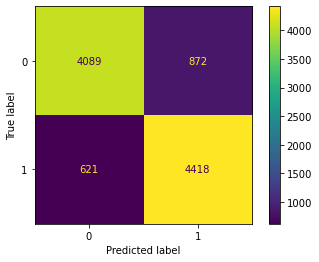

In [127]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])
print(classification_report(y_test,y_pred_cnn))

#FlOPS computation
flops = get_flops(cnn_model,batch_size=1)
print(f"Flops(CNN):{flops/10**9:.03}G")

#confusion matrix
cm = confusion_matrix(y_test, y_pred_cnn)
cm_display = ConfusionMatrixDisplay(cm).plot()

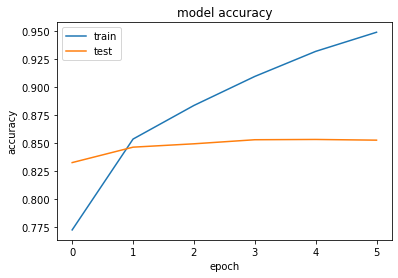

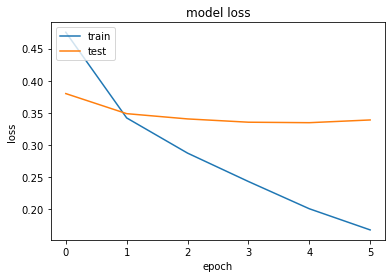

In [49]:
 #Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

# Recurrent nueral network (LSTM)

In [50]:
from keras.layers import LSTM

In [51]:
# Neural Network architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

In [52]:
# Model compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9,356,777
Trainable params: 117,377
Non-trainable params: 9,239,400
_________________________________________________________________
None


In [53]:
# Model Training

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 85s 330ms/step - loss: 0.5063 - acc: 0.7524 - val_loss: 0.4223 - val_acc: 0.8112
Epoch 2/6
250/250 [==============================] - 87s 346ms/step - loss: 0.4167 - acc: 0.8133 - val_loss: 0.4433 - val_acc: 0.7964
Epoch 3/6
250/250 [==============================] - 75s 298ms/step - loss: 0.3712 - acc: 0.8387 - val_loss: 0.3542 - val_acc: 0.8431
Epoch 4/6
250/250 [==============================] - 110s 441ms/step - loss: 0.3400 - acc: 0.8557 - val_loss: 0.3394 - val_acc: 0.8664
Epoch 5/6
250/250 [==============================] - 101s 406ms/step - loss: 0.3259 - acc: 0.8643 - val_loss: 0.3620 - val_acc: 0.8585
Epoch 6/6
250/250 [==============================] - 82s 329ms/step - loss: 0.3018 - acc: 0.8754 - val_loss: 0.3191 - val_acc: 0.8689


In [102]:
# Predictions on the Test Set
y_pred_lstm=lstm_model.predict(X_test)
score = lstm_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 17s 55ms/step - loss: 0.3217 - acc: 0.8637


In [109]:
#threshholding y_pred_lstm and converting real values to 0 and 1.
y_pred_lstm=np.array(y_pred_lstm)
y_pred_lstm.shape
m=len(y_pred_lstm)
for i in range(m):
    if y_pred_lstm[i]>0.5:
        y_pred_lstm[i]=1
    else:
        y_pred_lstm[i]=0
print(y_test.T[:5])
print(y_pred_lstm[:5])

[1 1 0 1 0]
[[0.]
 [1.]
 [0.]
 [1.]
 [0.]]


Test Score: 0.5635668635368347
Test Accuracy: 0.7472000122070312
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      4961
           1       0.89      0.83      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.86      0.86     10000

Flops(LSTM):2.57e-07G


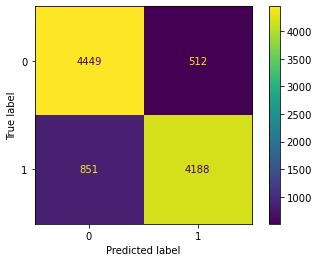

In [129]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])
print(classification_report(y_test,y_pred_lstm))

#FlOPS computation
flops = get_flops(lstm_model,batch_size=1)
print(f"Flops(LSTM):{flops/10**9:.03}G")

#confusion matrix
cm = confusion_matrix(y_test, y_pred_lstm)
cm_display = ConfusionMatrixDisplay(cm).plot()

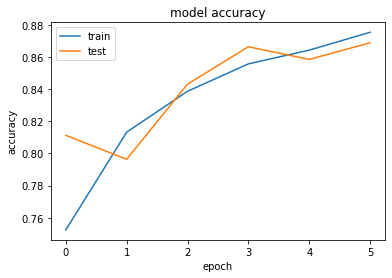

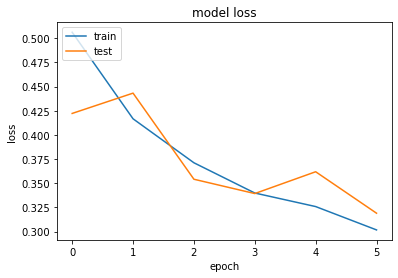

In [56]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()